# **1. Import Library**

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# **2. Memuat Dataset dari Hasil Clustering**

In [2]:
df = pd.read_csv('/content/clustering_result.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   CustomerAge              2512 non-null   int64  
 10  TransactionDuration      2512 non-null   int64  
 11  LoginAttempts            2512 non-null   int64  
 12  AccountBalance           2512 non-null   float64
 13  PreviousTransactionDate  2512 non-null   object 
 14  AgeGroup                

In [4]:
df.isna().sum()

,0
TransactionID,0
AccountID,0
TransactionAmount,0
TransactionDate,0
TransactionType,0
Location,0
DeviceID,0
IP Address,0
MerchantID,0
CustomerAge,0


In [5]:
df.drop(columns=['AgeGroup'], inplace=True)

Kolom AgeGroup dihapus karena sudah direpresentasikan oleh CustomerAge.

In [6]:
df_original = df.copy()

In [7]:
selected_features = [
    "TransactionAmount",
    "LoginAttempts",
    "FrekuensiTransaksi",
    "PenggunaanDevice",
    "IPAddressAccount",
    "TransactionType",
    "Channel"
]

In [8]:
df = df[selected_features + ["Cluster_KMeans"]]

Kolom yang tidak termasuk ke dalam variabel selected_features tidak dimasukkan untuk klasifikasi karena tidak relevan.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TransactionAmount   2512 non-null   float64
 1   LoginAttempts       2512 non-null   int64  
 2   FrekuensiTransaksi  2512 non-null   int64  
 3   PenggunaanDevice    2512 non-null   int64  
 4   IPAddressAccount    2512 non-null   int64  
 5   TransactionType     2512 non-null   object 
 6   Channel             2512 non-null   object 
 7   Cluster_KMeans      2512 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 157.1+ KB


In [10]:
# Label Encoding untuk TransactionType
df['TransactionType'] = df['TransactionType'].map({'Debit': 0, 'Credit': 1})

In [11]:
# One-Hot Encoding untuk Channel
df = pd.get_dummies(df, columns=['Channel'], drop_first=False)

In [12]:
scaler = MinMaxScaler()
df[['TransactionAmount']] = scaler.fit_transform(df[['TransactionAmount']])

In [13]:
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

In [14]:
# Mengubah nilai di dalam Cluster_KMeans berdasarkan hasil analisis Clustering
df['Cluster_KMeans'] = df['Cluster_KMeans'].map({
    0: 'Not Fraud',
    1: 'Not Fraud',
    2: 'Not Fraud',
    3: 'Not Fraud',
    4: 'Potential Fraud',
    5: 'Potential Fraud'
})

In [15]:
df['Cluster_KMeans'].value_counts()

,count
Cluster_KMeans,
Not Fraud,2188
Potential Fraud,324


In [16]:
# Label Encoding untuk Cluster_KMeans
df['Cluster_KMeans'] = df['Cluster_KMeans'].map({'Not Fraud': 0, 'Potential Fraud': 1})

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TransactionAmount   2512 non-null   float64
 1   LoginAttempts       2512 non-null   int64  
 2   FrekuensiTransaksi  2512 non-null   int64  
 3   PenggunaanDevice    2512 non-null   int64  
 4   IPAddressAccount    2512 non-null   int64  
 5   TransactionType     2512 non-null   int64  
 6   Cluster_KMeans      2512 non-null   int64  
 7   Channel_ATM         2512 non-null   int64  
 8   Channel_Branch      2512 non-null   int64  
 9   Channel_Online      2512 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 196.4 KB


# **3. Data Splitting**

In [27]:
# Memisahkan fitur dan target
X = df.drop(columns=['Cluster_KMeans'])
y = df['Cluster_KMeans']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
feature_names = X_train.columns.tolist()

In [30]:
# SMOTE untuk menyeimbangkan imbalanced dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribusi kelas sebelum SMOTE:", Counter(y_train))
print("Distribusi kelas setelah SMOTE:", Counter(y_train_resampled))

Distribusi kelas sebelum SMOTE: Counter({0: 1750, 1: 259})
Distribusi kelas setelah SMOTE: Counter({0: 1750, 1: 1750})


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Algoritma yang akan digunakan untuk model klasifikasi yaitu:
1. Decision Tree.

Model ini diterapkan karena cocok untuk klasifikasi biner, mudah diinterpretasikan, cepat dan efisien.

2. Logistic Regression.

Model ini digunakan karena sederhana dan efisien dan dapat menghindari overfitting.

3. Random Forest.

Model ini digunakan karena dapat menentukan fitur paling penting (feature importance) dan lebih stabil.

In [40]:
# Mengidentifikasi fitur yang paling relevan dengan RFE
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf_model, n_features_to_select=5)
rfe.fit(X_train_resampled_df, y_train_resampled)

selected_features = X_train_resampled_df.columns[rfe.support_]
print("Fitur yang dipilih oleh RFE:", selected_features)

Fitur yang dipilih oleh RFE: Index(['TransactionAmount', 'TransactionType', 'Channel_ATM', 'Channel_Branch',
       'Channel_Online'],
      dtype='object')


In [32]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model.predict(X_test)

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg_model.predict(X_test)

# Random Forest
X_train_selected = X_train_resampled_df[selected_features]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features]

# Latih ulang model dengan fitur terbaik
rf_model.fit(X_train_selected, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_selected)

## **b. Evaluasi Model Klasifikasi**

### **Decision Tree**

In [33]:
print("=== Decision Tree Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

=== Decision Tree Classifier ===
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      1.00      1.00        65

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



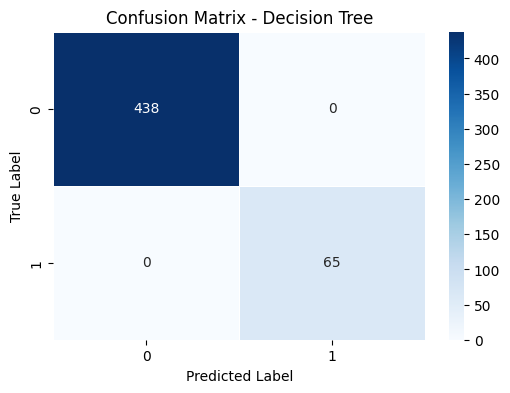

In [34]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

### **Logistic Regression**

In [35]:
print("=== Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))

=== Logistic Regression ===
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      1.00      1.00        65

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



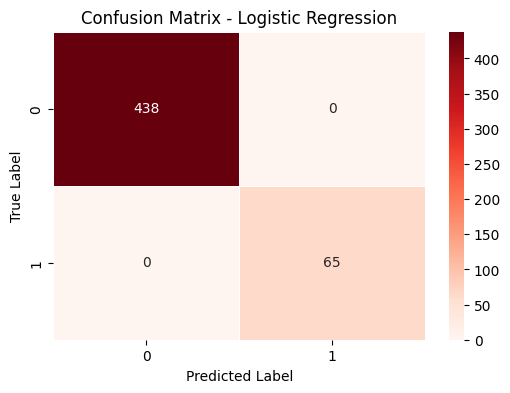

In [36]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6,4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Reds', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### **Random Forest**

In [37]:
print("=== Random Forest Classifier (Setelah RFE) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

=== Random Forest Classifier (Setelah RFE) ===
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      1.00      1.00        65

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



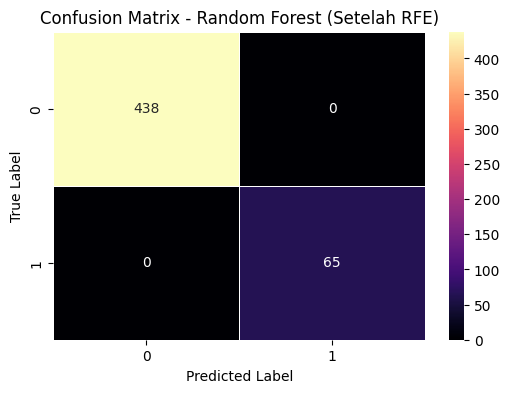

In [38]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='magma', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (Setelah RFE)")
plt.show()

Berikut perbandingan hasil 3 algoritma:
Semua model menghasilkan nilai akurasi dan F1-score 100% yang  artinya terjadi overfitting.

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

**Analisis**

1. Ketiga model menghasilkan nilai akurasi dan F1-score 100% yang artinya terjadi overfitting. Yaitu keadaan dimana model terlalu baik dalam pelatihan tetapi buruk dalam pengujian. Hal ini kemungkinan terjadi pada saat pemilihan fitur yang tidak tepat dan model yang terlalu kompleks sehingga menyebabkan overfitting.

2. Tindakan lebih lanjut bisa memilih kembali fitur mana saja yang paling relevan untuk klasifikasi dan mencoba memilih model lain sepeti Naive Bayes yang menggunakan prinsip probabilitas atau Support Vector Machine (SVM).